In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from datetime import timedelta
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import category_encoders as ce

# 온라인 스토어 유저 데이터 EDA
## 데이터 설명
- `2020-09-24 ~ 2020-12-21`에 걸쳐 일어난 온라인 스토어 유저 데이터
- 컬럼 설명
    - `event_time` : 이벤트 발생 시간
    - `event_type` : 발생한 이벤트 (view, cart, purchase)
    - `product_id` : 제품 id
    - `category_id` : 제품이 속한 카테고리 id
    - `category_code` : 제품이 속한 카테고리 코드
    - `price` : 가격
    - `user_id` : 로그인한 유저 id
    - `user_session` : 유저가 활동한 세션

In [6]:
file_path = "data/df_preprocessed.csv"
df = pd.read_csv(file_path)
# df.drop(['index'], axis = 1, inplace = True)
df.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_code_1,cat_code_2,cat_code_3
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,pitatel,31.9,1.520000e+18,LJuJVLEjPT,electronics,telephone,no_cat
1,2020-09-24 13:58:51+00:00,9,24,Thursday,13,view,790590,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,IBu02xVrhQ,computers,notebook,no_cat
2,2020-09-24 14:00:24+00:00,9,24,Thursday,14,view,790590,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,l68Br3I0Tl,computers,notebook,no_cat
3,2020-09-25 08:36:13+00:00,9,25,Friday,8,view,751693,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,6fTFbeiEqq,computers,notebook,no_cat
4,2020-09-30 16:16:16+00:00,9,30,Wednesday,16,view,751693,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,poHN5cBucr,computers,notebook,no_cat


In [7]:
df.isnull().sum()

event_time       0
month            0
day              0
day_name         0
hour             0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
cat_code_1       0
cat_code_2       0
cat_code_3       0
dtype: int64

In [8]:
df.loc[4653]

event_time       2020-10-18 06:15:56+00:00
month                                   10
day                                     18
day_name                            Sunday
hour                                     6
event_type                            view
product_id                         1203195
category_id          2140000000000000000.0
category_code           electronics.clocks
brand                              hitachi
price                                40.76
user_id              1520000000000000000.0
user_session                    G8qjxChCNV
cat_code_1                     electronics
cat_code_2                          clocks
cat_code_3                          no_cat
Name: 4653, dtype: object

## event_type 분석

### event_type 분포

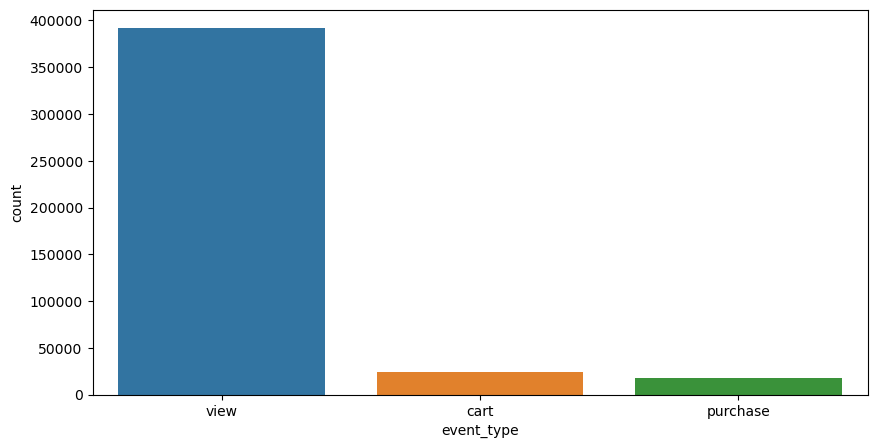

In [ ]:
# event_type 분포
plt.figure(figsize=(10, 5))
cnt = sns.countplot(x=df_copy2["event_type"])
plt.show()

In [ ]:
df_copy2["event_type"].value_counts(normalize=True)

event_type
view        0.902370
cart        0.056951
purchase    0.040679
Name: proportion, dtype: float64

### 요일별 고객 행동 분석

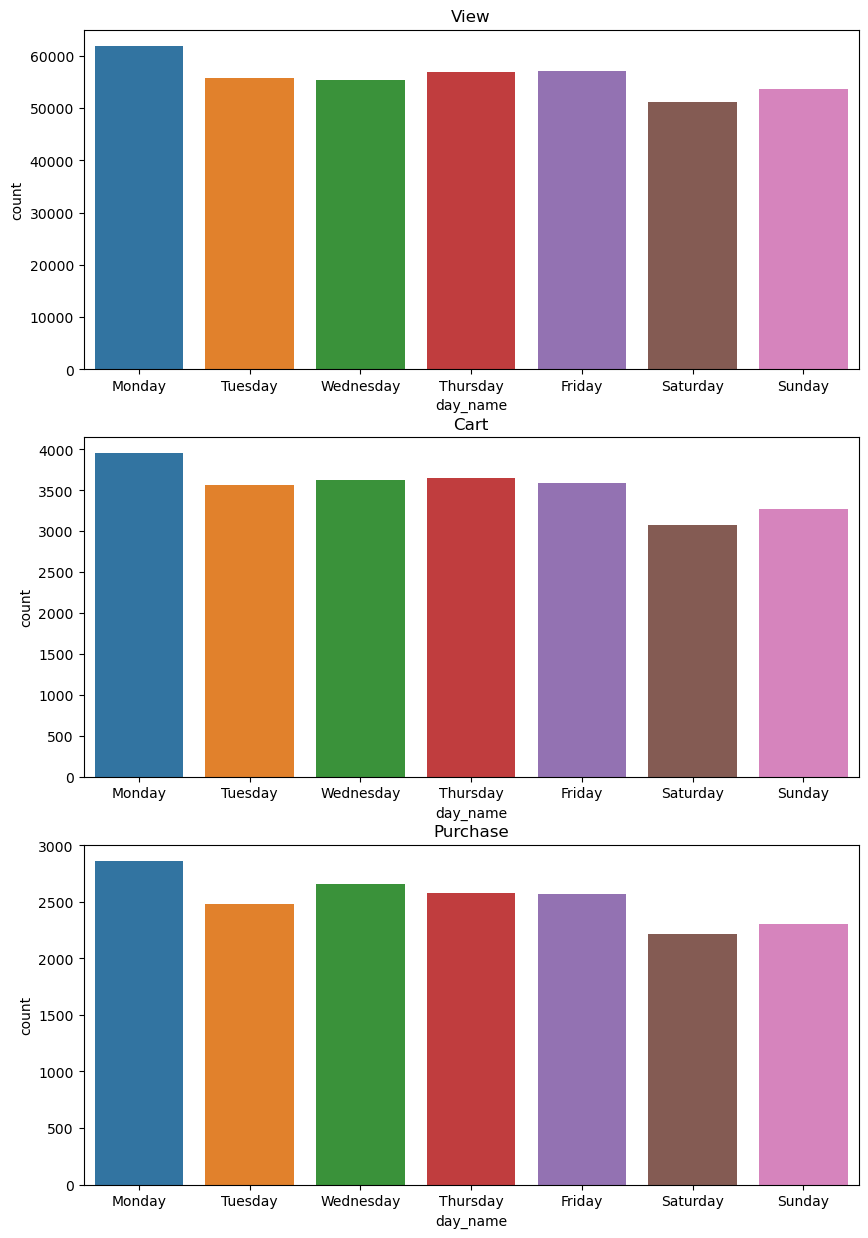

In [ ]:
# 상품 클릭, 장바구니, 구매 조건 설정
view_cond = (df_copy2["event_type"] == "view")
cart_cond = (df_copy2["event_type"] == "cart")
purchase_cond = (df_copy2["event_type"] == "purchase")

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 요일별 상품 클릭한 숫자
view_cnt = sns.countplot(x=df_copy2[view_cond]["day_name"],
                         order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],              
                         ax=ax[0])
view_cnt.set_title("View")

# 요일별 장바구니에 넣은 숫자
cart_cnt = sns.countplot(x=df_copy2[cart_cond]["day_name"],
                         order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                         ax=ax[1])
cart_cnt.set_title("Cart")

# 요일별 구매한 숫자
purchase_cnt = sns.countplot(x=df_copy2[purchase_cond]["day_name"],
                             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                             ax=ax[2])
purchase_cnt.set_title("Purchase")

plt.show()

### 시간대별 고객 행동 시각화

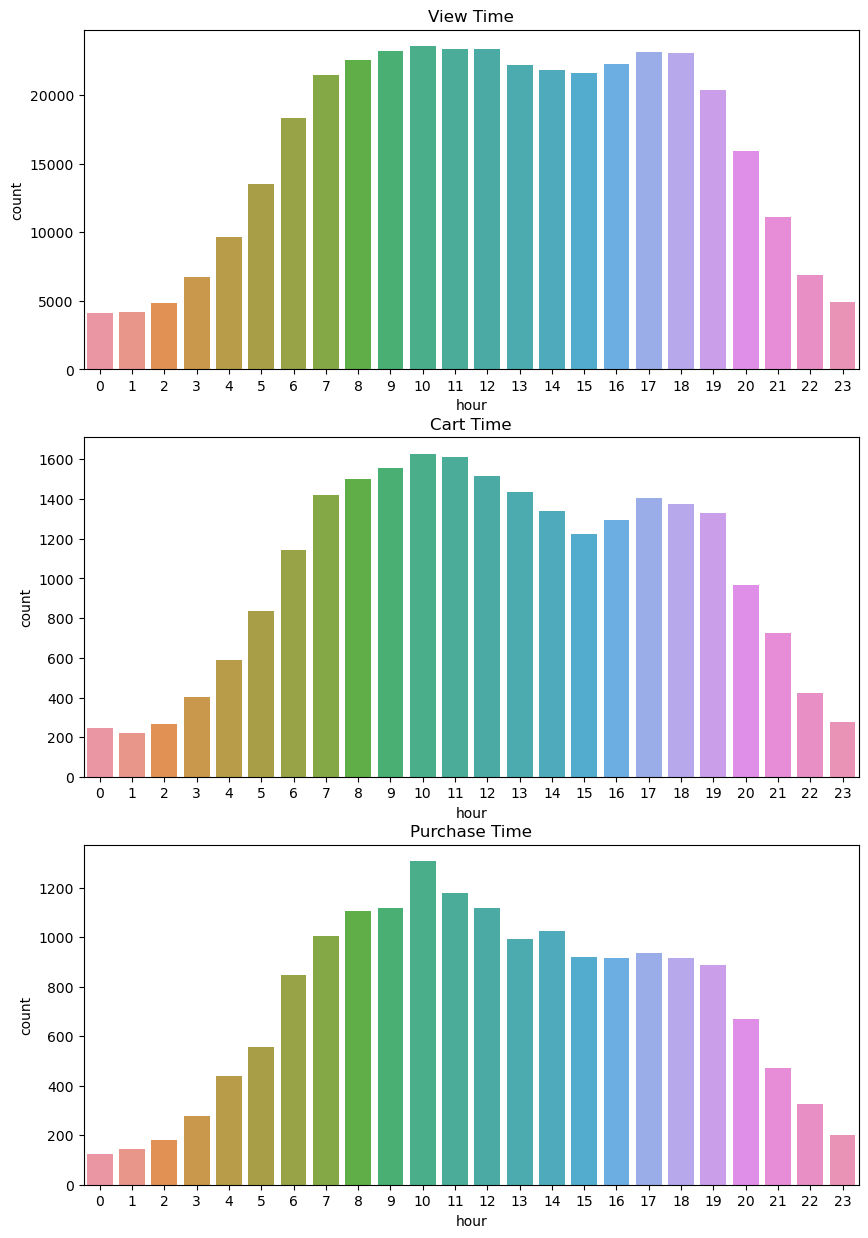

In [ ]:
# 시간대별 View, Cart, Purchase

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 시간별 상품 클릭한 숫자
view_time_cnt = sns.countplot(x=df_copy2[view_cond]["hour"],
                              ax=ax[0])
view_time_cnt.set_title("View Time")

# 시간별 장바구니에 넣은 숫자
cart_time_cnt = sns.countplot(x=df_copy2[cart_cond]["hour"],
                         ax=ax[1])
cart_time_cnt.set_title("Cart Time")

# 시간별 구매한 숫자
purchase_time_cnt = sns.countplot(x=df_copy2[purchase_cond]["hour"],
                             ax=ax[2])
purchase_time_cnt.set_title("Purchase Time")

plt.show()

### 구매전환율 (CVR, Conversion Rate) 구하기
- 사이트에 들어온 방문자가 실제 구매 활동을 하는 비율
- 구매전환율 = 전환수(구매횟수)/클릭수*100

In [ ]:
df_heat = df_copy2.copy()
# df_heat['event_time'] =  df_heat['event_time'].dt.to_period('D')

df_view_cvr = df_heat.loc[df_heat['event_type']=='view']
df_view_cvr = df_view_cvr[['event_time','user_session','price']]

df_pur_cvr = df_heat.loc[df_heat['event_type']=='purchase']
df_pur_cvr = df_pur_cvr[['event_time','user_session','price']]

In [ ]:
# view
df_date_view = df_view_cvr.groupby('event_time').count().reset_index()
# purchase
df_date_purchase = df_pur_cvr.groupby('event_time').count().reset_index()

# merge
df_cvr = pd.merge(df_date_view,df_date_purchase, on='event_time')


# cvr 컬럼추가
df_cvr['CVR'] = df_cvr['user_session_y']/df_cvr['user_session_x'] *100

In [ ]:
# 일별 매출
df_day_purchase = df_heat.loc[df_heat['event_type']=='purchase']
df_day_purchase['event_time'] =  df_day_purchase['event_time']

df_day_purchase = df_day_purchase[['event_time','price']]
df_day_purchase = df_day_purchase.groupby('event_time').sum().reset_index()

# merge

df_cvr = pd.merge(df_cvr,df_day_purchase, on='event_time')

df_cvr['weekday'] = df_cvr['event_time'].dt.weekday
df_cvr

C:\Users\IO\AppData\Local\Temp\ipykernel_8540\4292615488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day_purchase['event_time'] =  df_day_purchase['event_time']


,event_time,user_session_x,price_x,user_session_y,price_y,CVR,price,weekday
0,2020-09-24 12:49:24+00:00,1,1,1,1,100.0,36.03,3
1,2020-09-24 12:49:46+00:00,1,1,1,1,100.0,123.35,3
2,2020-09-24 15:48:48+00:00,1,1,1,1,100.0,23.48,3
3,2020-09-24 16:15:43+00:00,1,1,1,1,100.0,59.54,3
4,2020-09-25 06:54:46+00:00,1,1,1,1,100.0,251.92,4
...,...,...,...,...,...,...,...,...
1061,2020-12-21 14:22:06+00:00,1,1,2,2,200.0,139.77,0
1062,2020-12-21 16:46:06+00:00,1,1,1,1,100.0,482.52,0
1063,2020-12-21 18:01:56+00:00,1,1,1,1,100.0,10.48,0
1064,2020-12-21 18:55:49+00:00,1,1,1,1,100.0,370.46,0


#### 일일 매출, CVR 시각화

Text(0.5, 1.0, 'Daily CVR')

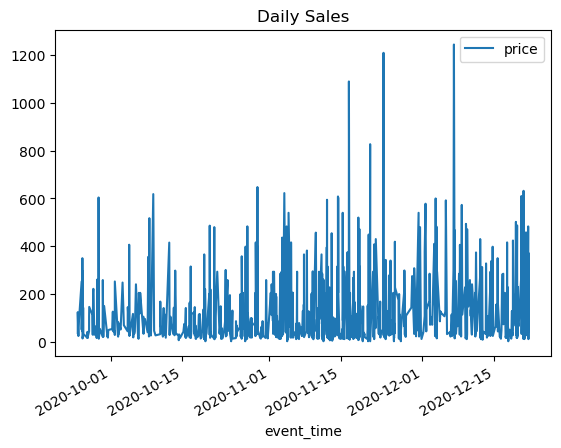

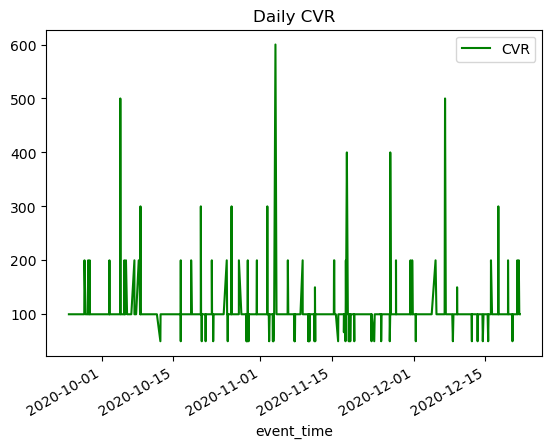

In [ ]:
# 일일 매출, CVR 시각화

sales_line = df_cvr.plot(x="event_time", y="price")
sales_line.set_title("Daily Sales")

cvr_line = df_cvr.plot(x="event_time", y="CVR", color="green")
cvr_line.set_title("Daily CVR")

## 생각해볼 것
- 고객 행동 분석
    - 전체적으로 월요일에 view, cart, purchase 횟수가 많다
        - 월요일에 특정 Action Plan 가져갈 수 있을까?
    - 시간대별 그래프도 view, cart, purchase 거의 비슷한 양상이지만, 17시 ~ 19시 사이 그래프 모양이 좀 다르다
        - purchase 오전 10시에 높지만, view, cart에 비해 17시 ~ 19시는 낮다

## 추가 진행 요소
- 결측치 처리 방법
- CVR 다시 구해보기
- 퍼널, 코호트 분석
